## Debugging the different versions

In [1]:
import numpy as np
from scipy import linalg as LA
import scipy.sparse.linalg as spla
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm 
from latex_envs.latex_envs import figcaption
#import chardet
import os
import h5py
import inspect
#for Latex font on figures
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Roman']})
rc('text', usetex=True)

/home/paraj/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# mod_LMG_v1 Tests

In [2]:
import mod_LMG_v1 as LMG
directory_debug='/home/paraj/Dropbox/Research_Projects_Current/LMG_Quench/data/debug/v1/Sz2t/'
all_functions = inspect.getmembers(LMG, inspect.isfunction)
print((all_functions))

[('LMG_generateHam', <function LMG_generateHam at 0x7f5794069ae8>), ('LMG_matrixelement', <function LMG_matrixelement at 0x7f57c420bb70>), ('Sz2', <function Sz2 at 0x7f5794069c80>), ('Sφ2', <function Sφ2 at 0x7f5794069d08>), ('magnetizationz2', <function magnetizationz2 at 0x7f5794069b70>), ('magnetizationφ2', <function magnetizationφ2 at 0x7f5794069bf8>), ('save_data_Sz2t', <function save_data_Sz2t at 0x7f5794069ea0>), ('save_data_Sφ2t', <function save_data_Sφ2t at 0x7f5794069f28>), ('time_evolved_Sz2', <function time_evolved_Sz2 at 0x7f5794069d90>), ('time_evolved_Sφ2', <function time_evolved_Sφ2 at 0x7f5794069e18>)]


Hermitian?:True
Exact eig-Sparse Eig=(-1.1368683772161603e-13+0j)
Exact energy gap=(0.5118896002231423+0j)
Sparse energy gap=(0.511889600223455+0j)


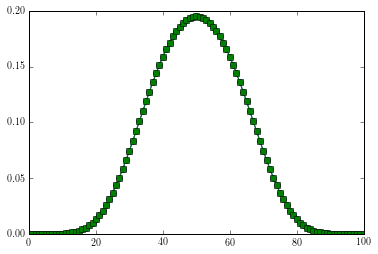

In [3]:
#create Hamiltonian, diagonalize, and plot a wavefunction
#tests : Ham_params,LMG_generateHam,LMG_matrixelement
paramvals=LMG.Ham_params(N=100.1,S=50,J=1,γz=1.,γy=0.,Γ=1.02)
Ham=LMG.LMG_generateHam(paramvals)
print("Hermitian?:"+str((Ham.transpose() == Ham).all())) #check hermitian
#diagonalize
Energies,Eigenvecs=LA.eig(Ham) #full diagonalize
SEnergies,SEigenvecs=spla.eigs(Ham,k=2,which="SR")#sparse diagonalize
idx = Energies.argsort()  
Energies =Energies[idx]
Eigenvecs = Eigenvecs[:,idx]
plt.plot(abs(Eigenvecs[:,0]),'-o')
plt.plot(abs(SEigenvecs[:,0]),'-s')
print("Exact eig-Sparse Eig="+str(Energies[0]-SEnergies[0]))
print("Exact energy gap="+str(Energies[1]-Energies[0]))
print("Sparse energy gap="+str(SEnergies[1]-SEnergies[0]))

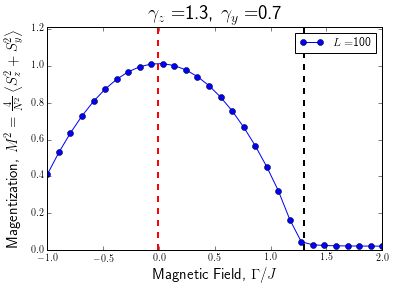

In [5]:
#calculate magnetization as a function of magnetic field
#tests magnetizationz2
Γarr=np.linspace(-1.,2,30)
Larr=np.arange(100,200,100)#choose even
magsqlist=np.ones([np.size(Γarr),np.size(Larr)])
for q in range(np.size(Larr)):
    L=Larr[q]
    for p in range(np.size(Γarr)):
        print([p,q], end='\r', flush=True)
        θ=np.pi/3
        paramvals=LMG.Ham_params(N=L,S=L/2,J=1,γz=1.3,γy=0.7,Γ=Γarr[p]) 
        Ham=LMG.LMG_generateHam(paramvals)
        GSenergy,vec=spla.eigs(Ham,k=1,which="SR")
        GState=vec[:,0]
        magsqlist[p,q]=LMG.magnetizationϕ2(GState,paramvals,1,0)+LMG.magnetizationϕ2(GState,paramvals,0,1)
criticalΓ=paramvals.J*max(paramvals.γz,paramvals.γy)
zerofield=-paramvals.J*np.sqrt(paramvals.γz*paramvals.γy)/paramvals.N
#plotting
plt.plot(Γarr, magsqlist,'-o')
plt.axvline(criticalΓ,linestyle='dashed',color= 'black',label='$Analytical $\\Gamma_c$',linewidth=2)
plt.axvline(zerofield,linestyle='dashed',color= 'red',label='$max magnetization',linewidth=2)
plt.ylim([0,np.max(magsqlist)+0.2])
plt.xlabel("Magnetic Field, $\\Gamma/J$",fontsize=15)
plt.ylabel("Magentization, $M^2=\\frac{4}{N^2}\\left\\langle S_z^2+S_y^2\\right\\rangle$",fontsize=15)
plt.title("$\\gamma_z=$"+str(paramvals.γz)+", $\\gamma_y=$"+str(paramvals.γy),fontsize=20)
leg = np.array(['$L=$%d' % p for p in Larr])
plt.legend(leg)
figcaption("Magnetization as a function of magnetic field with dashed line showing analytical expectation")


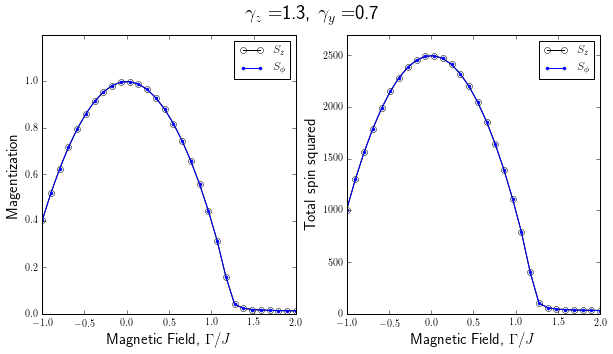

In [14]:
#test magnetizationz2 against magnetizationϕ2, and Sz2 against Sϕ2
Γarr=np.linspace(-1.,2,30)
Larr=np.arange(100,200,100)#choose even
magzsqlist=np.ones([np.size(Γarr),np.size(Larr)])
magϕsqlist=np.ones([np.size(Γarr),np.size(Larr)])
Szsqlist=np.ones([np.size(Γarr),np.size(Larr)])
Sϕsqlist=np.ones([np.size(Γarr),np.size(Larr)])
for q in range(np.size(Larr)):
    L=Larr[q]
    for p in range(np.size(Γarr)):
        print([p,q], end='\r', flush=True)
        θ=np.pi/3
        paramvals=LMG.Ham_params(N=L,S=L/2,J=1,γz=1.3,γy=0.7,Γ=Γarr[p]) 
        Ham=LMG.LMG_generateHam(paramvals)
        GSenergy,vec=spla.eigs(Ham,k=1,which="SR")
        GState=vec[:,0]
        magzsqlist[p,q]=LMG.magnetizationz2(GState,paramvals)
        magϕsqlist[p,q]=LMG.magnetizationϕ2(GState,paramvals,1,0)
        Szsqlist[p,q]=LMG.Sz2(GState,paramvals)
        Sϕsqlist[p,q]=LMG.Sϕ2(GState,paramvals,1,0)
#plotting
plt.figure(figsize=(10,5))
plt.suptitle("$\\gamma_z=$"+str(paramvals.γz)+", $\\gamma_y=$"+str(paramvals.γy),fontsize=20)
plt.subplot(1,2,1)
plt.plot(Γarr, magzsqlist,'-ko',label='$S_z$',markerfacecolor='none')
plt.plot(Γarr, magϕsqlist,'-b.',label='$S_\\phi$')
plt.ylim([0,np.max(magzsqlist)+0.2])
plt.xlabel("Magnetic Field, $\\Gamma/J$",fontsize=15)
plt.ylabel("Magentization",fontsize=15)
plt.legend()
plt.subplot(1,2,2)
plt.plot(Γarr, Szsqlist,'-ko',label='$S_z$',markerfacecolor='none')
plt.plot(Γarr, Sϕsqlist,'-b.',label='$S_\\phi$')
plt.ylim([0,np.max(Szsqlist)+200])
plt.xlabel("Magnetic Field, $\\Gamma/J$",fontsize=15)
plt.ylabel("Total spin squared",fontsize=15)
plt.legend()
figcaption("Comparing output between $S_z^2$ expectation with $S_\\phi^2$ where $A_z=1$ and $A_y=0$")


In [15]:
#testing time-evolved Sz2 and Sϕ2
L=100
paramvals0=LMG.Ham_params(N=L,S=L/2,J=1,γz=1.3,γy=0.7,Γ=Γarr[p]) 
    Ham0=LMG.LMG_generateHam(paramvals0)
    GSenergy,vec=spla.eigs(Ham0,k=1,which="SR")
    InitState=vec[:,0]
    print("Obtained Initial state.")
    #quench hamiltonian
    Hamf=LMG.LMG_generateHam(paramvalsf)
    U_dt=LA.expm(-1j*Hamf*dt)
    #time-evolved magnetization squared
    Sz2arr=np.zeros(Nsteps)
    Sz2arr=LMG.time_evolved_Sz2(InitState,Nsteps,U_dt,L)


IndentationError: unexpected indent (<ipython-input-15-e0a2e981a2ee>, line 3)

In [ ]:
#testing saving the data

In [6]:
#parameter defintions for analytical expressions
g0=paramvals0.Γ/paramvals0.J
gf=paramvalsf.Γ/paramvalsf.J
ω0=2*paramvals0.Γ*(1-1/g0)**0.5
ωf=2*paramvalsf.Γ*(1-1/gf)**0.5
ω0t=(1-1/g0)**0.5
ωft=(1-1/gf)**0.5
Sz2inf=(L/8)*(1/ω0t+(ω0t)/ωft**2)
Szt=(L/8)*((1/ω0t+(ω0t)/ωft**2)+(1/(ω0t)-(ω0t)/ωft**2)*np.cos(2*(ωf)*(np.linspace(0,Tf,1000))))

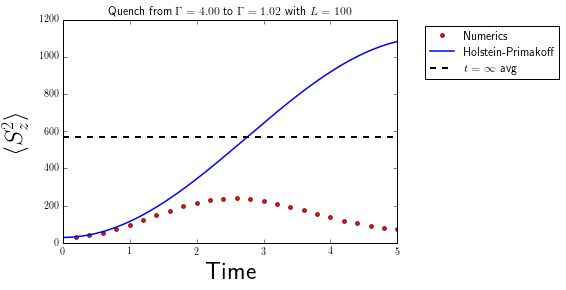

In [7]:
#plotting
plt.plot(tarr,Sz2arr,'o',color='red',markersize=4,label='Numerics')
plt.plot(np.linspace(0,Tf,1000),Szt,color='blue',label='Holstein-Primakoff',linewidth=1.5)
plt.axhline(Sz2inf,linestyle='dashed',color= 'black',label='$t=\\infty$ avg',linewidth=2)
plt.xlabel("Time",fontsize=25)
plt.ylabel("$\\langle S_z^2\\rangle$",fontsize=25)
plt.xlim(0,5)
plt.legend(numpoints=1,bbox_to_anchor=(1.5,1))
plt.title('Quench from $\\Gamma= %.2f $ to $\\Gamma= %.2f $ with $L=%d$'%(paramvals0.Γ, paramvalsf.Γ,L))
figname='/home/paraj/Dropbox/Research_Projects_Current/LMG_Quench/plots/Sz2t_[0_'+str(dt)+'_'+str(Tf)+']_from_'+paramvals0.paramstr()+'to'+paramvalsf.paramstr()+'.pdf'

plt.savefig(figname,bbox_inches="tight")

# $L$ dependence of the time-averaged-$\langle S_z^2\rangle$
Here we discuss the dependence on system size of the time-averaged correlator. Basically, regardless of what the quench parameter is the analytical solution using H-P approximation should get better for larger system size. Let us verify this claim.
\begin{enumerate}
\item Quench to the critical point. $H_0\equiv \{J_0=1$, $\gamma_0=0$, $\Gamma_0=4\}$ to $H_f\equiv \{J_f=1$, $\gamma_f=0$, $\Gamma_f=1\}$ 
\item  Quench from and to the critical point. $H_0\equiv \{J_0=1$, $\gamma_0=0.1$, $\Gamma_0=4\}$ to $H_f\equiv \{J_f=1$, $\gamma_f=0.8$, $\Gamma_f=1\}$ 
\end{enumerate}

## Figure-1: Quench to the critical point. $H_0\equiv \{J_0=1$, $\gamma_0=0$, $\Gamma_0=4\}$ to $H_f\equiv \{J_f=1$, $\gamma_f=0$, $\Gamma_f=1\}$

In [2]:
Larr=np.concatenate([np.arange(100,1000,100),np.arange(1000,6000,1000)]) #Set system size.
dt=0.2 #time step
Tf=20 # final time step
Nsteps=int(Tf/dt) 
tarr=np.arange(dt,Tf+dt,dt)

In [3]:
directory1='data/Sz2t/'
directory2='/home/paraj/Dropbox/Research_Projects_Current/LMG_Quench/data/Sz2t/'
Sz2vals=np.zeros((Nsteps,np.size(Larr)))
for L,p in zip(Larr,range(np.size(Larr))):
    print('L='+str(L), end='\r', flush=True)
    paramvals0=LMG.Ham_params(N=L,S=L/2,J=1.0,γ=0.1,Γ=4.0)
    paramvalsf=LMG.Ham_params(N=L,S=L/2,J=1.0,γ=0.1,Γ=1.0)
    filename=directory2+'Sz2t_[0_'+str(dt)+'_'+str(dt*Nsteps)+']_from_'+paramvals0.paramstr()+'_to_'+paramvalsf.paramstr()+'.hdf5'
    #print(filename)
    if not os.path.exists(filename):
        print("Data file does not exist:\n"+filename+"Run simulations.")
    else:
        print("Loading file: ", end='\r', flush=True)
        with h5py.File(filename, "r") as f:
            Sz2arr= f["Sz2arr"][...]
            InitState=f["InitState"][...]
        Sz2vals[:,p]=Sz2arr

Data file does not exist:
/home/paraj/Dropbox/Research_Projects_Current/LMG_Quench/data/Sz2t/Sz2t_[0_0.2_20.0]_from_L_600,S_300.0,J_1.0,Γ_4.0,γ_0.1_to_L_600,S_300.0,J_1.0,Γ_1.0,γ_0.1.hdf5Run simulations.


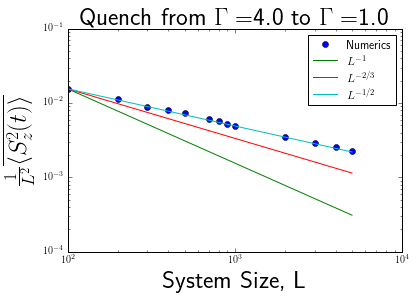

In [4]:
#Plot average magnetization as a function of L
##numerical formulae
Sztavg=np.mean(Sz2vals, axis=0)
#plt.loglog(Larr,np.divide(np.abs(Sz2infarr-Sztavg),(Sz2infarr)),'o')
plt.figure()
plt.loglog(Larr,np.divide(Sztavg,Larr**2),'o',label='Numerics')
plt.loglog(Larr,np.divide(Sztavg,Larr**2)[0]*Larr[0]/Larr,'-',label='$L^{-1}$')
plt.loglog(Larr,np.divide(Sztavg,Larr**2)[0]*(Larr[0]/Larr)**(2/3),'-',label='$L^{-2/3}$')
plt.loglog(Larr,np.divide(Sztavg,Larr**2)[0]*(Larr[0]/Larr)**(1/2),'-',label='$L^{-1/2}$')
plt.ylabel('$\\frac{1}{L^2}\\overline{\\langle S_z^2(t)\\rangle}$',fontsize=25)
plt.xlabel('System Size, L',fontsize=25)
plt.title('Quench from $\\Gamma=$'+str(paramvals0.Γ)+' to $\\Gamma=$'+str(paramvalsf.Γ),fontsize=25)
plt.legend(loc=1,numpoints=1)
figcaption("Quench to the critical point. It is clear that the scaling with system size is $\sim N^{-1/2}$ which indicates a thermal type behavior" )

## Figure 2: Quench from and to the critical point. $H_0\equiv \{J_0=1$, $\gamma_0=0.1$, $\Gamma_0=1\}$ to $H_f\equiv \{J_f=1$, $\gamma_f=0.8$, $\Gamma_f=1\}$ 

In [5]:
Larr=np.concatenate([np.arange(100.0,1000,100),np.arange(1000.0,5000,1000)]) #Set system size.
dt=0.2 #time step
Tf=20 # final time step
Nsteps=int(Tf/dt) 
tarr=np.arange(dt,Tf+dt,dt)

In [7]:
directory1='data/Sz2t/'
directory2='/home/paraj/Dropbox/Research_Projects_Current/LMG_Quench/data/Sz2t/'
Sz2vals=np.zeros((Nsteps,np.size(Larr)))
for L,p in zip(Larr,range(np.size(Larr))):
    print('L='+str(L), end='\r', flush=True)
    paramvals0=LMG.Ham_params(N=L,S=L/2,J=1.0,γ=0.1,Γ=1.0)
    paramvalsf=LMG.Ham_params(N=L,S=L/2,J=1.0,γ=0.8,Γ=1.0)
    filename=directory2+'Sz2t_[0_'+str(dt)+'_'+str(dt*Nsteps)+']_from_'+paramvals0.paramstr()+'_to_'+paramvalsf.paramstr()+'.hdf5'
    #print(filename)
    if not os.path.exists(filename):
        print("Data file does not exist:\n"+filename+"Run simulations.")
    else:
        print("Loading file: ", end='\r', flush=True)
        with h5py.File(filename, "r") as f:
            Sz2arr= f["Sz2arr"][...]
            InitState=f["InitState"][...]
        Sz2vals[:,p]=Sz2arr

In [11]:
Larr

array([ 100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,  900.,
       1000., 2000., 3000., 4000.])

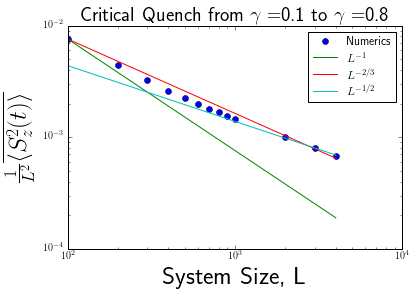

In [17]:
#Plot average magnetization as a function of L
##numerical formulae
Sztavg=np.mean(Sz2vals, axis=0)
#plt.loglog(Larr,np.divide(np.abs(Sz2infarr-Sztavg),(Sz2infarr)),'o')
plt.figure()
plt.loglog(Larr,np.divide(Sztavg,Larr**2),'o',label='Numerics')
plt.loglog(Larr,np.divide(Sztavg,Larr**2)[0]*Larr[0]/Larr,'-',label='$L^{-1}$')
plt.loglog(Larr,np.divide(Sztavg,Larr**2)[0]*(Larr[0]/Larr)**(2/3),'-',label='$L^{-2/3}$')
plt.loglog(Larr,np.divide(Sztavg,Larr**2)[0]*(Larr[0]/(Larr*3))**(1/2),'-',label='$L^{-1/2}$')
plt.ylabel('$\\frac{1}{L^2}\\overline{\\langle S_z^2(t)\\rangle}$',fontsize=25)
plt.xlabel('System Size, L',fontsize=25)
plt.title('Critical Quench from $\\gamma=$'+str(paramvals0.γ)+' to $\\gamma=$'+str(paramvalsf.γ),fontsize=20)
plt.legend(loc=1,numpoints=1)
figcaption("Quench to the critical point. It is clear that the scaling with system size is $\sim N^{-2/3}$ which indicates a thermal type behavior" )